# Project 01: one protein against many ligands 

The purpose is to find interaction hotspots in a single target through the analysis of interactions found in a dataset of diverse small compounds.

This was used in the prototype pipeline to elucidate hotspots in the sars-cov-19 protease, and we will refine it here against other datasets.

The workflow itself consists of three steps:

1. Obtaining and sanitizing the data
2. Ingesting it in `plipify`
3. Generating publication-worthy figures

In [89]:
from pathlib import Path
from io import BytesIO
from zipfile import ZipFile
from subprocess import call, STDOUT

import requests
from tqdm.auto import tqdm
from matplotlib import cm, colors
from IPython.display import Image
import pandas as pd
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame
from Bio.PDB import PDBParser, PDBIO
import nglview as nv

from plipify.fingerprints import InteractionFingerprint
from plipify.visualization import (
    fingerprint_barplot, fingerprint_heatmap, fingerprint_table, 
    fingerprint_nglview, PymolVisualizer, nglview_color_side_chains_by_frequency,
    fingerprint_writepdb
)
from plipify.core import Structure

Query Fragalysis for all downloadable targets.

In [2]:
r = requests.get(f"https://fragalysis.diamond.ac.uk/api/targets/?format=json")
r.raise_for_status()
targets = [t["title"] for t in r.json()["results"] if t["zip_archive"]]
print("Downloadable targets:", *targets)

Downloadable targets: NUDT7A ATAD BRD1A DCP2B FAM83BA MURD NUDT4A OXA10OTA PARP14A PHIPA PTP1B SMTGR ACVR1A ATAD2A CAMK1DA DCLRE1AA FALZA HAO1A MUREECA NUDT21A NUDT4 NUDT5A NUDT7A_CRUDE smTGRNEW STAG1A TBXTA VIM2 XX02KALRNA TNCA ALAS2A EPB41L3A mArh INPP5DA nsp13 Mac1 Mpro NSP15_B MUREECOLI PGN_RS02895PGA CD44MMA


In [3]:
TARGET = "Mpro"  # other options, see above

HERE = Path(_dh[-1])
DATA = HERE / "data" / TARGET
OUT = HERE / "output" / TARGET
DATA.mkdir(exist_ok=True, parents=True)
OUT.mkdir(exist_ok=True, parents=True)

## Obtaining and sanitizing the data

We will be using data from [_Fragalysis_](), a XRC platform that generates structures for ligand collections against a given target. API endpoint is described [here](https://fragalysis.diamond.ac.uk/api/?format=api), but in short, it seems that you can download a full featured zip file using this URL: `https://fragalysis.diamond.ac.uk/media/targets/$TARGETNAME.zip`.

In [4]:
r = requests.get(f"https://fragalysis.diamond.ac.uk/api/targets/?format=json&title={TARGET}")
r.raise_for_status()
target = r.json()["results"][0]

if target["zip_archive"] is None:
    raise ValueError(f"Target {TARGET} is not downloadable")

crystal_name RealCrystalName  \
1     Mpro-x11271_0A     Mpro-x11271   
2     Mpro-x11041_0A     Mpro-x11041   
3      Mpro-x1002_0A      Mpro-x1002   
4     Mpro-x10155_0A     Mpro-x10155   
6      Mpro-x1101_1A      Mpro-x1101   
...              ...             ...   
1270   Mpro-P2010_0A      Mpro-P2010   
1271   Mpro-P2011_0A      Mpro-P2011   
1272   Mpro-P0154_0A      Mpro-P0154   
1273   Mpro-P1062_0B      Mpro-P1062   
1274   Mpro-P1062_0A      Mpro-P1062   

                                                 smiles  \
1                COC=1C=C(Cl)C=C(CC(=O)NC=2C=NC=CC2C)C1   
2                 CN(C(=O)CC=1C=CC=C(Cl)C1)C=2C=NC=CC2C   
3                                          OC=1C=CC=CN1   
4                   CC(N1CCN(Cc2cnc(Cc3ccccc3)s2)CC1)=O   
6                         CC(C)N(C)C=1N=CN=C2N(C)N=CC12   
...                                                 ...   
1270          ClC=1C=CC=C(CC(=O)NC=2C=NC=C3N=CC=CC23)C1   
1271            ClC=1C=CC=C(CC(=O)NN2N=NC=3C=CC=CC23)C1   
1272  ClC=1C=CC=2OCCC(CNC(=O)CN3C=CN=C3)(C(=O)NC=4C=...   
1273  CC1CCN(C1)S(=O)(=O)N2CC(C(=O)NC=3C=NC=C4C=CC=C...   
1274  CC1CCN(C1)S(=O)(=O)N2CC(C(=O)NC=3C=NC=C4C=CC=C...   

                               new_smiles       alternate_name  \
1                                     NaN   MAT-POS-c9973a83-1   
2                                     NaN  JAN-GHE-83b26c96-15   
3                                     NaN  AAR-POS-0daf6b7e-37   
4     CC(N1CCN(Cc2cnc(Cc3ccccc3)s2)CC1)=O  MED-COV-4280ac29-25   
6                                     NaN  AAR-POS-0daf6b7e-40   
...                                   ...                  ...   
1270                                  NaN   MIC-UNK-08cd9c58-1   
1271                                  NaN   MAT-POS-bfb445d4-2   
1272                                  NaN   EDG-MED-70ae9412-1   
1273                                  NaN  MAT-POS-4223bc15-11   
1274                                  NaN  MAT-POS-4223bc15-11   

                        site_name pdb_entry  \
1              Aminopyridine-like       NaN   
2              Aminopyridine-like       NaN   
3     XChem Screen - xtal contact      5RF4   
4                 Chloroacetamide       NaN   
6     XChem Screen - xtal contact      5RGR   
...                           ...       ...   
1270                 Isoquinoline       NaN   
1271                Benzotriazole       NaN   
1272                 Isoquinoline       NaN   
1273                 Isoquinoline       NaN   
1274                 Isoquinoline       NaN   

                                                  ROMol  
1     <img data-content="rdkit/molecule" src="data:i...  
2     <img data-content="rdkit/molecule" src="data:i...  
3     <img data-content="rdkit/molecule" src="data:i...  
4     <img data-content="rdkit/molecule" src="data:i...  
6     <img data-content="rdkit/molecule" src="data:i...  
...                                                 ...  
1270  <img data-content="rdkit/molecule" src="data:i...  
1271  <img data-content="rdkit/molecule" src="data:i...  
1272  <img data-content="rdkit/molecule" src="data:i...  
1273  <img data-content="rdkit/molecule" src="data:i...  
1274  <img data-content="rdkit/molecule" src="data:i...  

[587 rows x 8 columns]
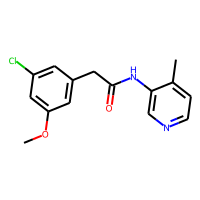
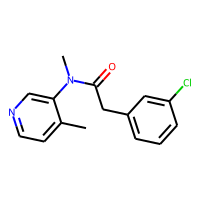
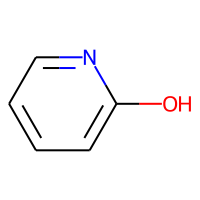
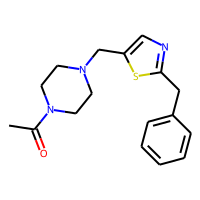
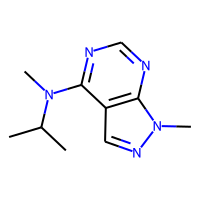
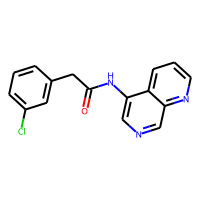
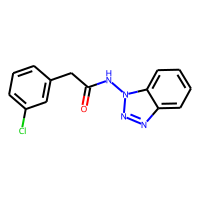
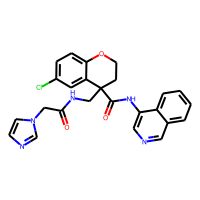
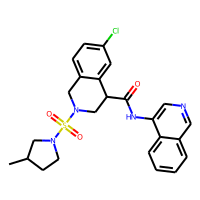
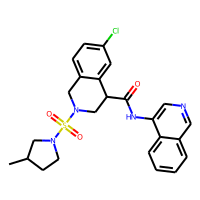

In [5]:
metadata = requests.get(target["metadata"], stream=True)
metadata = pd.read_csv(metadata.raw, index_col=0)
AddMoleculeColumnToFrame(metadata, smilesCol="smiles")
metadata

Prealigned PDBs for each row can be found in `data/{target}/aligned/{crystal_name}/{crystal_name}_bound.pdb`:

In [10]:
# If already downloaded, they should be here:
pdbs = list((DATA / "aligned").glob("**/*_bound.pdb"))

if not pdbs:
    download_url = target["zip_archive"]
    
    # NOTE: As of 2021.10.13, MPro dataset URL gives a 502 gateway error
    # The webapp uses https://zenodo.org/record/5226381 instead for MPro
    # We will use this one for now if that's the case
    if target["title"] == "Mpro":
        download_url = "https://zenodo.org/record/5226381/files/Mpro.zip?download=1"
        
    response = requests.get(download_url, stream=True)
    response.raise_for_status()
    with BytesIO(response.raw.data) as b, ZipFile(b) as z:
        z.extractall(DATA)
    # Reassign now
    pdbs = list((DATA / "aligned").glob("**/*_bound.pdb"))
    assert pdbs, "Couldn't find downloaded PDB structures!"
    
print(f"# structures: {len(pdbs)}")

# structures: 587


The archive for MPro keeps changing contents (more structures being added), so we will filter the structures with the contents retrieved on 2021.07.07 for the sake of reproducibility.

In [15]:
if TARGET == "Mpro":
    all_pdbs = pdbs.copy()
    with open(HERE / "20210707_Mprodata.txt") as f:
        contents = set()
        for line in f:
            line = line.strip()
            if line.endswith(".pdb"):
                contents.add(line)
    pdbs = [pdb for pdb in all_pdbs 
            if str(Path(pdb).relative_to(HERE)) in contents]
    print("Filtered structures down to", len(pdbs), "files")

Filtered structures down to 493 files


As the directory name suggests, these are prealigned:

In [16]:
view = nv.NGLWidget()
for pdb in pdbs[:10]:
    structure = nv.adaptor.FileStructure(str(pdb))
    comp = view.add_component(structure, default_representation=False)
    comp.add_cartoon()
    comp.add_ball_and_stick("LIG")
view.center("LIG")
view

NGLWidget()

In [17]:
view.render_image(factor=1, trim=True, transparent=True, antialias=True);

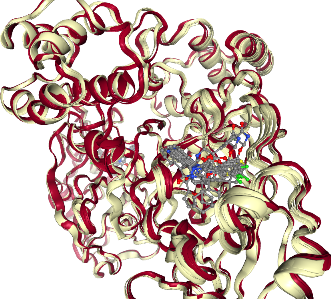

In [18]:
view._display_image()

Notice how binding sites are not always the same.

### Split files by chain
To get one binding site per protein only

In [22]:
# If already split, they should be here:
pdbs_by_chain = list((DATA / "aligned").glob("**/*_bound_chain*[!wH].pdb"))

if not pdbs_by_chain:
    not_processed = []
    for path in tqdm(pdbs):
        chain_id = path.stem.split('_')[1][-1]
        new_filename = path.parent / f"{path.stem}_chain{chain_id}{path.suffix}"

        ## Read the PDB file and extract the chain from structure[0]
        model = PDBParser(PERMISSIVE=1,QUIET=1).get_structure(pdb_id, filepath)[0]
        ### Save new file
        if chain_id in model:
            io = PDBIO()
            io.set_structure(model[chain_id])
            io.save(str(new_filename))
        else:
            not_processed.append(path)
    
    # Reassign now
    pdbs_by_chain = list((DATA / "aligned").glob("**/*_bound_chain*[!wH].pdb"))

print(f"# structures: {len(pdbs_by_chain)}")
print(f"Could not process {len(not_processed)} structures:")
print(" -", "\n - ".join(map(str, not_processed)))

  0%|          | 0/493 [00:00<?, ?it/s]

# structures: 488
Could not process 5 structures:


TypeError: sequence item 0: expected str instance, PosixPath found

In [26]:
print(" -", "\n - ".join(map(str, not_processed)))

 - /opt/conda-src/projects/01/data/Mpro/aligned/Mpro-z3d23_0C/Mpro-z3d23_0C_bound.pdb
 - /opt/conda-src/projects/01/data/Mpro/aligned/Mpro-z3d23_0D/Mpro-z3d23_0D_bound.pdb
 - /opt/conda-src/projects/01/data/Mpro/aligned/Mpro-z4ylu_0C/Mpro-z4ylu_0C_bound.pdb
 - /opt/conda-src/projects/01/data/Mpro/aligned/Mpro-z4ylu_0D/Mpro-z4ylu_0D_bound.pdb
 - /opt/conda-src/projects/01/data/Mpro/aligned/Mpro-z6jij_0C/Mpro-z6jij_0C_bound.pdb


# Protonate
Some ligands/residues are potentially incorrectly protonated with PLIP builtin fixers (OpenBabel). In this example, we take care of that using Amber's `reduce`.

In [27]:
def reduce(path):
    path = Path(path)
    output = path.parent / f"{path.stem}_wH{path.suffix}"
    with open(output, "wb") as f:
        call(["reduce", path], stdout=f, stderr=STDOUT)
    return output

In [28]:
# If already Hs added, they should be here:
pdbs_by_chain_wH = list((DATA / "aligned").glob("**/*_bound_chain*_wH.pdb"))

if not pdbs_by_chain_wH:
    pdbs_by_chain_wH = [reduce(pdb) for pdb in tqdm(pdbs_by_chain)]

print(f"# structures: {len(pdbs_by_chain_wH)}")
print(pdbs_by_chain_wH[0:3])

  0%|          | 0/488 [00:00<?, ?it/s]

# structures: 488
[PosixPath('/opt/conda-src/projects/01/data/Mpro/aligned/Mpro-P0008_0A/Mpro-P0008_0A_bound_chainA_wH.pdb'), PosixPath('/opt/conda-src/projects/01/data/Mpro/aligned/Mpro-P0008_0B/Mpro-P0008_0B_bound_chainB_wH.pdb'), PosixPath('/opt/conda-src/projects/01/data/Mpro/aligned/Mpro-P0009_0A/Mpro-P0009_0A_bound_chainA_wH.pdb')]


Check structures

In [29]:
import nglview as nv

view = nv.NGLWidget()
for pdb in pdbs_by_chain_wH[:10]:
    structure = nv.adaptor.FileStructure(str(pdb))
    comp = view.add_component(structure, default_representation=False)
    comp.add_cartoon()
    comp.add_ball_and_stick("LIG")
view.center("LIG")
view

NGLWidget()

## Ingesting it in `plipify` 

TBD.

In [31]:
structures = []
for path in tqdm(pdbs_by_chain_wH):
    structure = Structure.from_pdbfile(str(path), ligand_name="LIG")
    if len(structure.binding_sites) != 1:
        print(f"{path.relative_to(HERE)} contains {len(structure.binding_sites)} binding sites and we want exactly one.")
        continue
    structures.append(structure)

  0%|          | 0/488 [00:00<?, ?it/s]

### Rudimentary filter to exclude artifacts
* by sequence length deviation
* and those containing gaps
* **tmp fix**: Needed to revert the structure list, otherwise the different sequence sizes (304 and 305) caused an error, and excluded one structure at the end for same reason (#TODO)

Note: The gap filter was neede to avoid error when generating interatcion fingerprints `ValueError: Length mismatch: Expected axis has 296 elements, new values have 305 element`

In [32]:
_structures = structures.copy()

In [37]:
structures.sort(key=lambda s: len(s.sequence()), reverse=True)

In [38]:
lengths = pd.DataFrame([((s.identifier), len(s.sequence()), s.sequence()) for s in structures], columns=["identifier", "length", "sequence"])
# Remove entries where the difference sequence length - median sequence length is greater than one standard deviation
print('Sequence length median and std:', lengths.length.median(), lengths.length.std())

Sequence length median and std: 306.0 0.28074865410104266


In [39]:
lengths["gapcount"] = lengths.sequence.str.count('-')
lengths[lengths.gapcount>0]

identifier  length  \
446  Mpro-z7ldx_0B_bound_chainB_wH     305   
447  Mpro-z7l14_0B_bound_chainB_wH     305   
448  Mpro-z7l11_0B_bound_chainB_wH     305   
449  Mpro-z7kvr_0B_bound_chainB_wH     305   
450  Mpro-z6jij_0B_bound_chainB_wH     305   
451  Mpro-z5gwy_0B_bound_chainB_wH     305   
452  Mpro-z5c5o_0B_bound_chainB_wH     305   
453  Mpro-z4ylu_0B_bound_chainB_wH     305   
454  Mpro-z3d23_0B_bound_chainB_wH     305   
455  Mpro-z2zu2_0B_bound_chainB_wH     305   
456  Mpro-z2q6g_0B_bound_chainB_wH     305   
457  Mpro-P1015_0B_bound_chainB_wH     305   
458  Mpro-P0996_0B_bound_chainB_wH     305   
459  Mpro-P0661_0B_bound_chainB_wH     305   
460  Mpro-P0602_0B_bound_chainB_wH     305   
461  Mpro-P0224_0B_bound_chainB_wH     305   
462  Mpro-P0213_0B_bound_chainB_wH     305   
463  Mpro-P0208_0B_bound_chainB_wH     305   
464  Mpro-P0187_0B_bound_chainB_wH     305   
465  Mpro-P0157_0B_bound_chainB_wH     305   
466  Mpro-P0108_0B_bound_chainB_wH     305   
467  Mpro-P0075_0B_bound_chainB_wH     305   
468  Mpro-P0069_0B_bound_chainB_wH     305   
469  Mpro-P0066_0B_bound_chainB_wH     305   
470  Mpro-P0065_0B_bound_chainB_wH     305   
471  Mpro-P0063_0B_bound_chainB_wH     305   
472  Mpro-P0061_0B_bound_chainB_wH     305   
473  Mpro-P0060_0B_bound_chainB_wH     305   
474  Mpro-P0057_0B_bound_chainB_wH     305   
475  Mpro-P0056_0B_bound_chainB_wH     305   
476  Mpro-P0039_0B_bound_chainB_wH     305   
477  Mpro-P0034_0B_bound_chainB_wH     305   
478  Mpro-P0033_0B_bound_chainB_wH     305   
479  Mpro-P0031_0B_bound_chainB_wH     305   
480  Mpro-P0030_0B_bound_chainB_wH     305   
481  Mpro-P0022_0B_bound_chainB_wH     305   
482  Mpro-P0019_0B_bound_chainB_wH     305   
483  Mpro-P0017_0B_bound_chainB_wH     305   
484  Mpro-P0016_0B_bound_chainB_wH     305   
485  Mpro-P0012_0B_bound_chainB_wH     305   
486  Mpro-P0010_0B_bound_chainB_wH     305   
487  Mpro-P0008_0B_bound_chainB_wH     305   

                                              sequence  gapcount  
446  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
447  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
448  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
449  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
450  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
451  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
452  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
453  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
454  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
455  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
456  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
457  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
458  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
459  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
460  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
461  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
462  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
463  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
464  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
465  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
466  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
467  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
468  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
469  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
470  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
471  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
472  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
473  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
474  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6  
475  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGL

In [40]:
# delete those with varying sequence length
lengths = lengths[(lengths.length - lengths.length.median()).abs() < lengths.length.std()]
# delete those with gaps
lengths = lengths[lengths.gapcount==0]
filtered_structures = [s for s in structures if s.identifier in set(lengths.identifier.tolist())]
print('pdbs', len(pdbs_by_chain_wH), "-> structures", len(structures), "-> final", len(filtered_structures))
print(len(pdbs_by_chain_wH) - len(filtered_structures), "structures filtered out")

structures = filtered_structures

pdbs 488 -> structures 488 -> final 446 = 42 structures filtered out


In [41]:
# count type of structures
n_structures_by_type = {'Mpro-P': 0, 'Mpro-x': 0, 'Mpro-z': 0, 'other': 0}
for s in structures:
    name_code = s.identifier[0:6]
    if name_code in n_structures_by_type:
        n_structures_by_type[name_code] += 1
    else:
        n_structures_by_type['other'] += 1
print(n_structures_by_type)

{'Mpro-P': 63, 'Mpro-x': 364, 'Mpro-z': 19, 'other': 0}


In [42]:
# Review
fp = InteractionFingerprint().calculate_fingerprint(
        structures[1:], # see comment above excluded Mpro-z structure
        labeled=True, 
        as_dataframe=True, 
        remove_non_interacting_residues=True,
        remove_empty_interaction_types=True,
        ensure_same_sequence=False
    )

if not fp.values.shape[0]:
    raise ValueError("Fingerprint is empty!")

In [43]:
fp.style.background_gradient(axis=None, cmap="YlGnBu")

This fingerprint is too sparse, let's try to focus on the hotspots only (arbitrarily defined now as "residue with more than 5 total interactions, regardless the type")

In [44]:
fp_focused = fp[fp.sum(axis=1) > 5]

In [45]:
fp_focused.style.background_gradient(axis=None, cmap="YlGnBu")

### We pick the lead compound methoxy for visualization purposes

In [56]:
structures[0].identifier

'Mpro-z7lfp_0A_bound_chainA_wH'

In [57]:
# selected_name = "Mpro-P0157_0B"  # this one has gaps!
selected_name = "Mpro-z7lfp_0A"  # use a random one; AV review this!
selected_structure = next(s for s in structures if selected_name in s.identifier)
selected_pdb = next(p for p in pdbs_by_chain_wH if selected_name in str(p))

In [59]:
view = nglview_color_side_chains_by_frequency(fp_focused, selected_pdb)
view

NGLWidget()

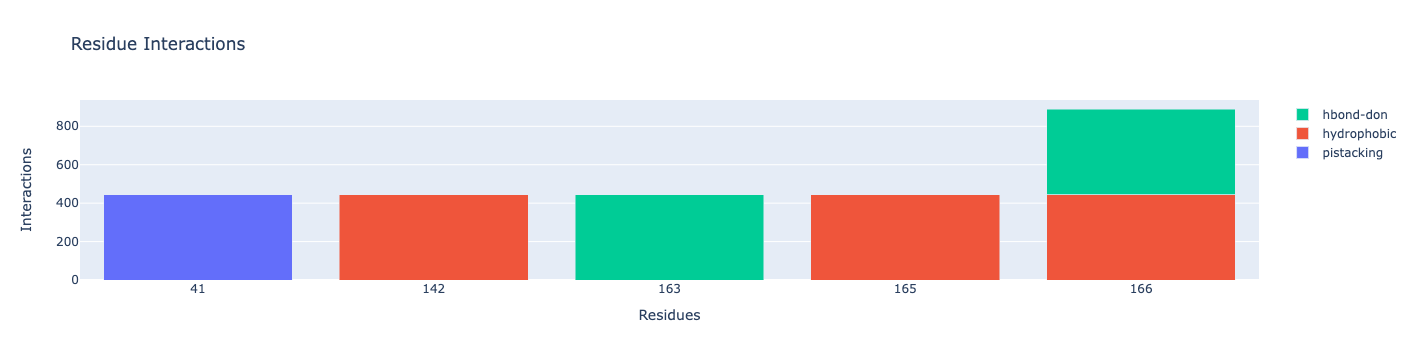

In [60]:
fingerprint_barplot(fp_focused)

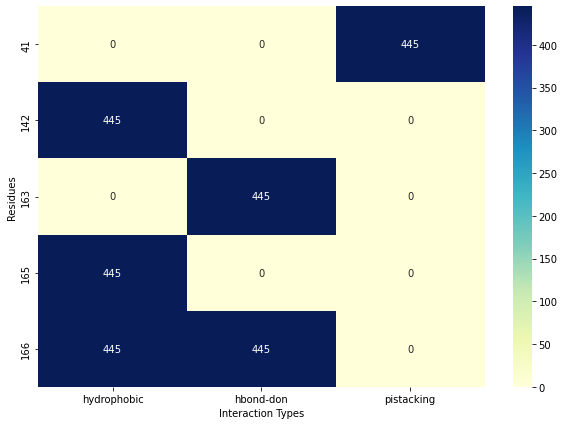

In [61]:
fingerprint_heatmap(fp_focused, cmap="YlGnBu");

In [62]:
fingerprint_table(fingerprint_df=fp_focused, structure=structures[0])

HTML(value='\n    <style>\n    \n\n    table.plipify-legend {\n        text-align: center;\n        color: #ff…

In [63]:
view = fingerprint_nglview(fp_focused, selected_structure)
view.center("LIG")
view

NGLWidget()

In [64]:
view.render_image(factor=1, trim=True, transparent=True, antialias=True);

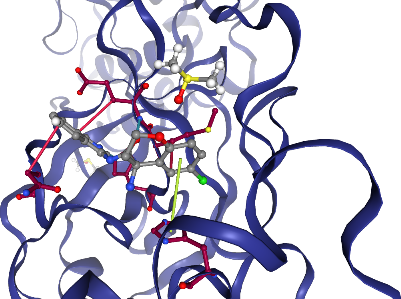

In [65]:
view._display_image()

In [67]:
selected_structure.to_dataframes();

### LIG:A:404

#### Hydrophobic

RESNR RESTYPE RESCHAIN RESNR_LIG RESTYPE_LIG RESCHAIN_LIG  DIST  \
0   142     ASN        A       404         LIG            A  3.97   
0   165     MET        A       404         LIG            A  3.59   
0   166     GLU        A       404         LIG            A  3.72   

  LIGCARBONIDX PROTCARBONIDX                      LIGCOO  \
0         4709          2201     (-4.816, 1.448, -21.69)   
0         4723          2522  (-12.282, -1.901, -21.904)   
0         4713          2539    (-5.661, 0.869, -19.093)   

                     PROTCOO  
0   (-2.709, -1.904, -21.94)  
0  (-12.695, 0.285, -19.086)  
0   (-8.308, 3.405, -18.438)

#### Hbond-Don

RESNR RESTYPE RESCHAIN RESNR_LIG RESTYPE_LIG RESCHAIN_LIG SIDECHAIN  \
0   166     GLU        A       404         LIG            A     False   
0   163     HIS        A       404         LIG            A      True   

  DIST_H-A DIST_D-A DON_ANGLE PROTISDON DONORIDX DONORTYPE ACCEPTORIDX  \
0     2.23     3.04    157.79      True     2537       Nam        4716   
0     1.71     2.66    160.49      True     2494       Nar        4729   

  ACCEPTORTYPE                     LIGCOO                    PROTCOO  
0           O2    (-9.97, 0.378, -21.025)  (-10.302, 1.986, -18.468)  
0          Nar  (-7.173, -0.231, -17.549)  (-8.354, -1.069, -15.315)

#### Pistacking

RESNR RESTYPE RESCHAIN RESNR_LIG RESTYPE_LIG RESCHAIN_LIG  \
0    41     HIS        A       404         LIG            A   

         PROT_IDX_LIST CENTDIST  ANGLE OFFSET TYPE  \
0  608,609,610,611,612     5.28  71.06   0.95    T   

                    LIG_IDX_LIST  \
0  4722,4723,4724,4725,4726,4727   

                                              LIGCOO  \
0  (-12.836666666666664, -0.9305, -22.73583333333...   

                                    PROTCOO  
0  (-12.3446, -5.978199999999999, -21.2752)

In [68]:
selected_structure.view()

NGLWidget()

In [69]:
view.render_image(factor=1, trim=True, transparent=True, antialias=True);

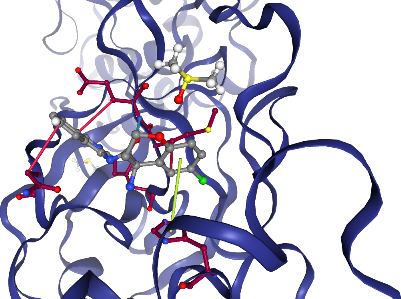

In [70]:
view._display_image()

## Generating publication-worthy figures

TBD.

Below is an example of 1) Creating PDB files for each interaction type found by `InteractionFingerprint().calculate_fingerprint()` and 2) Producing images of these using the PyMol API.

Note: The current hard-coded view is based on MPro

In [71]:
# Using the methoxy ligand as an example
# TODO need to adapt view to use the wH structure
methoxy = Structure.from_pdbfile(path="./data/Mpro/aligned/Mpro-P0157_0A/Mpro-P0157_0A_bound_chainA_wH.pdb") 

Create individual PDB files based on the interaction type, this will produce PDB files with bfactor values per residue representing the number of ligand interactions at that particular site. 

We also set the `summed` flag to `True` to add up all interactions and generate a PDB file containing all interaction types summed together.

In [78]:
pdb_interactions = fingerprint_writepdb(fingerprint_df=fp, structure=methoxy, output_path=OUT, ligand=True, summed=True, verbose=False)

In [79]:
pdb_interactions

{'hydrophobic': <Structure with 306 residues, 1 ligands (0 of which were ignored) and 1 characterized binding sites. (loaded from file `/opt/conda-src/projects/01/output/Mpro/interaction_pdbs/sys_int_hydrophobic.pdb`)>,
 'hbond-don': <Structure with 306 residues, 1 ligands (0 of which were ignored) and 1 characterized binding sites. (loaded from file `/opt/conda-src/projects/01/output/Mpro/interaction_pdbs/sys_int_hbond-don.pdb`)>,
 'pistacking': <Structure with 306 residues, 1 ligands (0 of which were ignored) and 1 characterized binding sites. (loaded from file `/opt/conda-src/projects/01/output/Mpro/interaction_pdbs/sys_int_pistacking.pdb`)>,
 'summed_interactions': <Structure with 306 residues, 1 ligands (0 of which were ignored) and 1 characterized binding sites. (loaded from file `/opt/conda-src/projects/01/output/Mpro/interaction_pdbs/sys_summed_interactions.pdb`)>}

We will use the `VisPymol` class to make a figure of all interactions summed. 

This is the color palette:
 * 0: `hydrophobic` - forest
 * 1: `hbond-don` - deepblue
 * 2: `hbond-acc` - olive
 * 3: `saltbridge` - purple
 * 4: `pistacking` - brown 
 * 5: `pication` - lightpink
 * 6: `halogen` - gray
 * 7: `summed_interactions` - yellow

In [91]:
spectrum_colors = {
    "hydrophobic": "white_forest", 
    "hbond-don": "white_deepblue", 
    "hbond-acc": "white_olive", 
    "saltbridge": "white_purple", 
    "pistacking": "white_brown", 
    "pication": "white_lightpink", 
    "halogen": "white_gray", 
    "summed_interactions": "white_yellow"
}

# supply view from PyMol "get_view" command
mpro_view = "\
            -0.665904999,   -0.394821048,   -0.632996082,\
            0.296537369,   -0.918650806,    0.261042088,\
            -0.684570849,   -0.013875127,    0.728814185,\
            0.000000000,    0.000000000,  -95.144737244,\
            8.413966179,   -0.994599819,   22.830898285,\
            56.102233887,  134.187240601,   20.000000000 "

for interaction_name, interaction_structure in pdb_interactions.items():
    v = PymolVisualizer(pdb=interaction_structure._path, verbose=False)
    v.set_style()
    v.create_image(
        surface=True, ligand_col="cyan", spectrum_col=spectrum_colors[interaction_name], 
        view=mpro_view, viewport_x=900, viewport_y=900
    )
    v.render(name=f"{interaction_name}_pymol_image", save_path=str(OUT))

PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900


Show sample figure

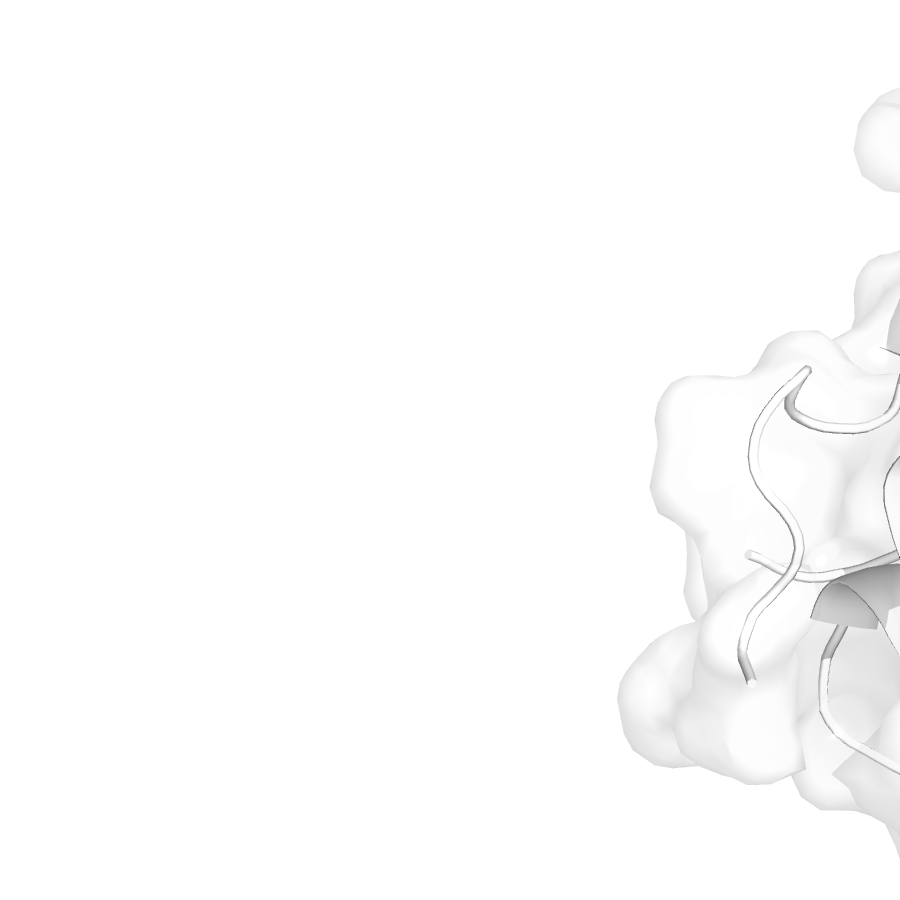

In [94]:
Image(filename=OUT / "summed_interactions_pymol_image.png", width=300, height=300)

We also may want to remove the ligand from the image, this can be done with the `show_ligand` flag: 

In [97]:
for interaction_name, interaction_structure in pdb_interactions.items():
    v = PymolVisualizer(pdb=interaction_structure._path, verbose=False)
    v.set_style()
    v.create_image(
        surface=True, ligand_col="cyan", spectrum_col=spectrum_colors[interaction_name],
        show_ligand=False, view=mpro_view, viewport_x=900, viewport_y=900)
    v.render(name=f"{interaction_name}_pymol_image_no_ligand", save_path=OUT)

PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900


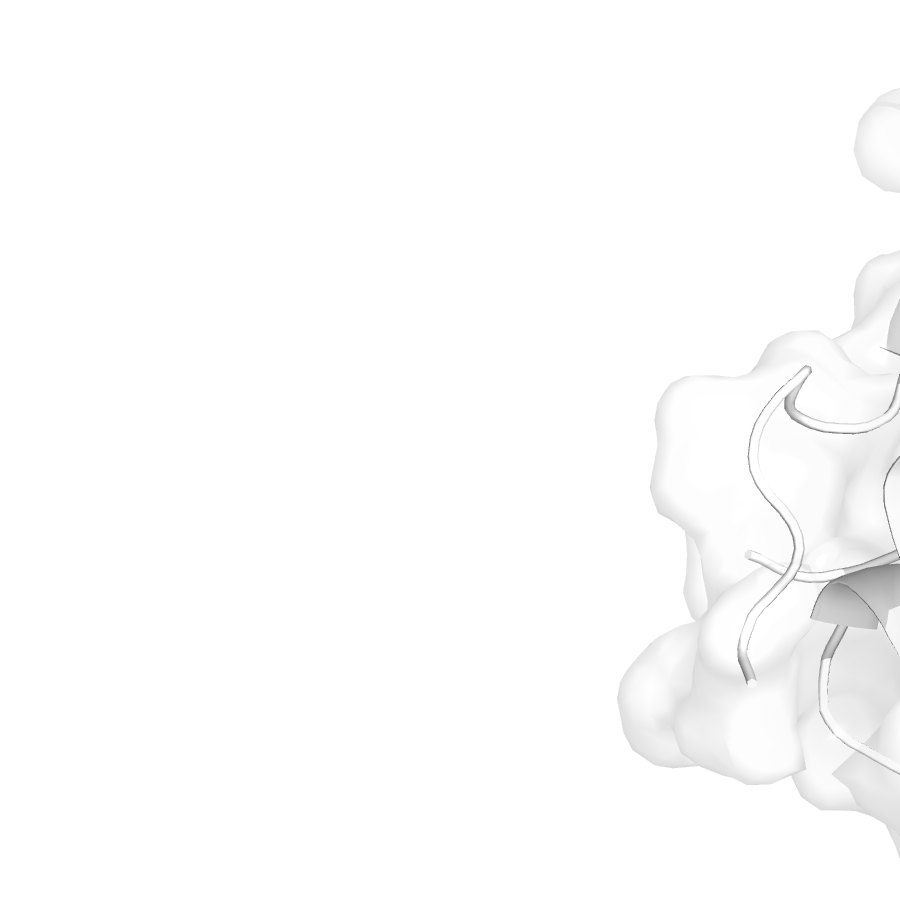

In [101]:
Image(filename=OUT / "summed_interactions_pymol_image_no_ligand.png", width=300, height=300) 

Sometimes when rendering residues as "sticks" they can appear to float above beta sheets. One way to get around this is to ensure beta sheets follow the backbone residues (at a cost of visual aesthetics) e.g.

In [100]:
for interaction_name, interaction_structure in pdb_interactions.items():
    v = PymolVisualizer(pdb=interaction_structure._path, verbose=False)
    v.set_style(flat_sheets=0)
    v.create_image(
        surface=True, ligand_col="cyan", spectrum_col=spectrum_colors[interaction_name],
        show_ligand=False, view=mpro_view, viewport_x=900, viewport_y=900)
    v.render(name=f"{interaction_name}_pymol_image_no_ligand_undulating_sheets", save_path=OUT)

PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900


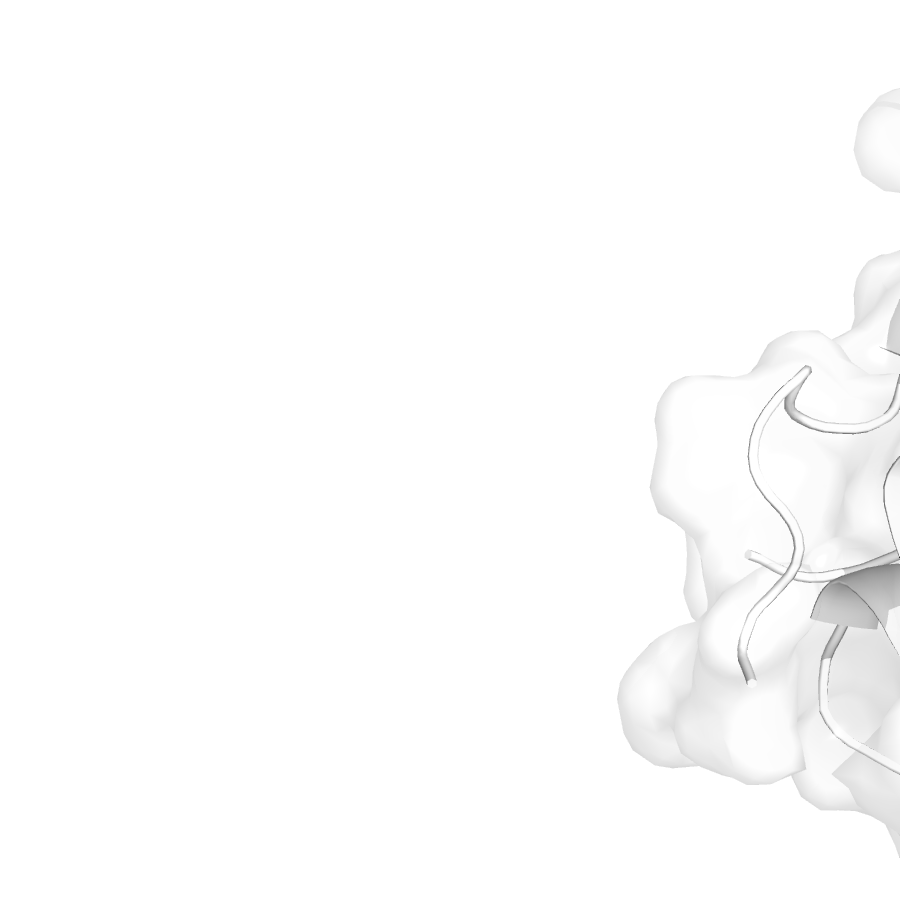

In [102]:
Image(filename=OUT / "summed_interactions_pymol_image_no_ligand_undulating_sheets.png", width=300, height=300)